# All 19 Sites!

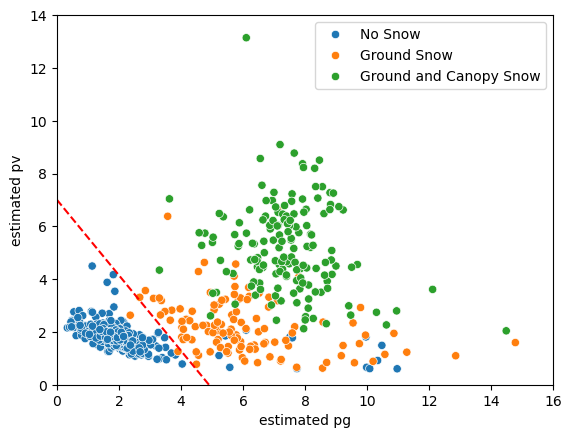

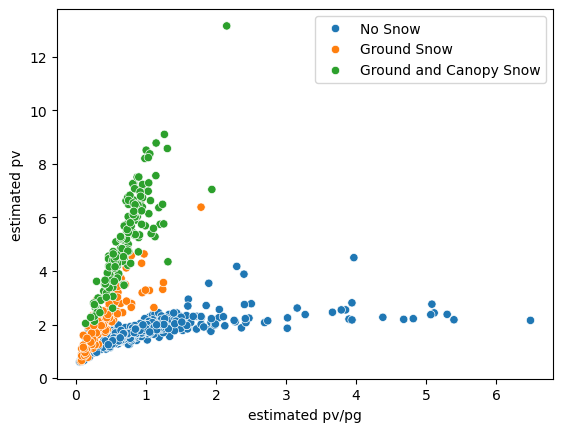

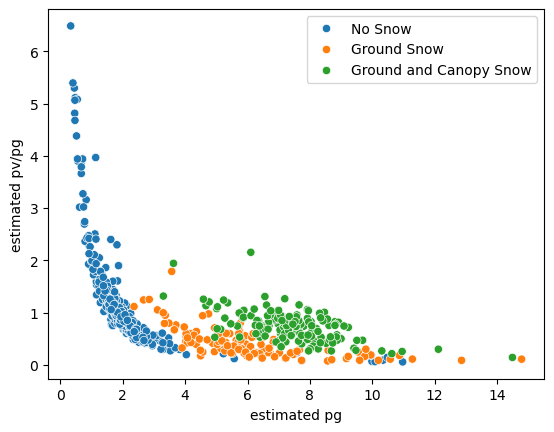

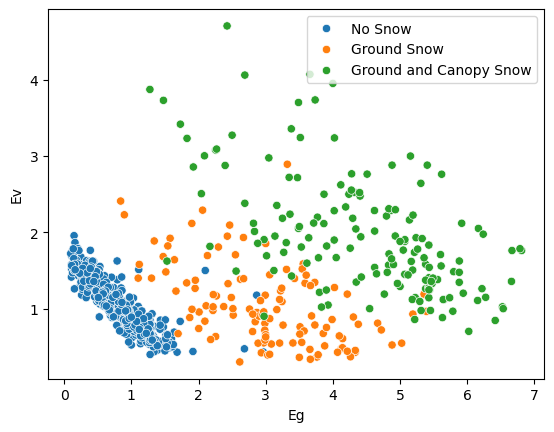

In [88]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_outlier22_th3_1km_noprior_ta_DW.pkl')
# print(df.columns)
# mask = df['beam'] == 3
# df.loc[mask, ['pv','pg','Ev','Eg']] /= 0.85

# First create masked columns
df['Eg_strong'] = np.where(df['beam_str'] == 'strong', df['Eg'], np.nan)
df['Ev_strong'] = np.where(df['beam_str'] == 'strong', df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    &(df_grouped['pv_ratio_mean'] >= 1.3)
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.round(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,16)
plt.ylim(0,14)
plt.plot([4.9,0],[0,7],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated pv')
# plt.xlim(0,3)
# plt.ylim(0,12)
# plt.plot([0.29,0.29],[0,1.32],'r--')
# plt.plot([0.5,0.5],[1.53,7],'r--')
# plt.plot([0.3,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv/pg')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='Eg_strong', y='Ev_strong', hue='Conditions')#, size='data_quantity')
plt.xlabel('Eg')
plt.ylabel('Ev')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

In [89]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Assuming your dataframe is called df
# features = ['pvpg', 'pv', 'pg', 'snr', 'pv_ratio_mean', 'pv_ratio_max']
features = ['pv', 'pg', 'pvpg','Ev_strong','Eg_strong']
target = 'JointSnowBinary'

data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

X = data[features]
y = data[target]

# Optional: standardize the features (helps logistic regression perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression on all data
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_scaled, y)

# Predict on the same data (since you said to use all data)
y_pred = model.predict(X_scaled)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Get boolean mask of incorrect predictions
incorrect_mask = y != y_pred

# Optionally convert y to numpy array if needed
# y = y.to_numpy()

# Get the misclassified rows from the original dataframe
misclassified = data[incorrect_mask]

# Add true and predicted labels to the misclassified DataFrame for inspection
misclassified = misclassified.copy()
misclassified['TrueLabel'] = y[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show the result
misclassified.sort_values(['JointSnow','camera','date'])

Confusion Matrix:
[[396   4]
 [  8 271]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.99      0.97      0.98       279

    accuracy                           0.98       679
   macro avg       0.98      0.98      0.98       679
weighted avg       0.98      0.98      0.98       679



,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,data_quantity,...,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,JointSnowBinary,TrueLabel,PredictedLabel
867,old_jack_pine,07/05/2019,53.929814,-104.730241,0.066127,0.660441,9.987482,2.682927,0.473684,22.500000,...,0.000000,4.0,2.000000,1.546578,1.546578,0.0,No Snow,0,0,1
1010,old_jack_pine,29/04/2023,53.902786,-104.638463,0.060428,0.609558,10.087268,2.965024,0.431926,27.641509,...,1.000000,20.0,0.000000,2.543752,2.543752,0.0,No Snow,0,0,1
2003,willowcreek,15/06/2019,45.774468,-90.111409,0.339425,2.070325,6.099500,2.100000,1.500000,27.592593,...,0.000000,3.0,0.425926,1.715100,1.715100,0.0,No Snow,0,0,1
2021,willowcreek,15/06/2019,45.837532,-90.059714,0.234107,1.776802,7.589692,2.865762,1.176471,30.500000,...,0.000000,3.0,0.250000,1.827154,1.827154,0.0,No Snow,0,0,1
304,glees,28/05/2023,41.386923,-106.209391,1.115044,2.633419,2.361718,1.101516,1.400000,25.745098,...,0.000000,19.0,0.627451,1.841683,1.841683,1.0,Ground Snow,1,1,0
633,lacclair,03/04/2024,46.938586,-71.676199,0.515285,2.100746,4.076860,1.300000,1.400000,21.190476,...,0.738095,22.0,0.000000,1.866963,1.866963,1.0,Ground Snow,1,1,0
635,lacclair,03/04/2024,46.956605,-71.715793,0.791686,2.642093,3.337298,1.117647,1.579832,22.714286,...,1.000000,22.0,0.000000,2.019023,2.019023,1.0,Ground Snow,1,1,0
2023,willowcreek,28/02/2024,45.774468,-90.033867,0.252156,1.245572,4.939681,1.869195,0.883440,27.384615,...,0.000000,17.0,0.000000,1.978498,1.978498,1.0,Ground Snow,1,1,0
2029,willowcreek,28/02/2024,45.792486,-90.033867,0.124762,0.899797,7.212112,2.254755,0.634675,25.297872,...,0.000000,17.0,0.000000,1.391414,1.391414,1.0,Ground Snow,1,1,0
2032,willowcreek,28/02/2024,45.801495,-90.033867,0.322774,1.259369,3.901705,1.695502,0.672269,23.400000,...,0.000000,17.0,0.000000,1.943611,1.943611,1.0,Ground Snow,1,1,0


In [90]:
import pandas as pd

# Define the features and target
features = ['pv', 'pg', 'pvpg']
target = 'JointSnowBinary'

# Ensure binary classification for the target
data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

# Apply simple classification rule
data['PredictedLabel'] = (data['pv'] >= (-7 / 4.9) * data['pg'] + 7).astype(int)

# Evaluate predictions
y_true = data['JointSnowBinary']
y_pred = data['PredictedLabel']

from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Get misclassified rows
incorrect_mask = y_true != y_pred
misclassified = data[incorrect_mask].copy()
misclassified['TrueLabel'] = y_true[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show misclassified results
misclassified.sort_values(['JointSnow', 'camera', 'date'])


Confusion Matrix:
[[387  13]
 [  2 277]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.96      0.99      0.97       279

    accuracy                           0.98       679
   macro avg       0.98      0.98      0.98       679
weighted avg       0.98      0.98      0.98       679



,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,data_quantity,...,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,JointSnowBinary,PredictedLabel,TrueLabel
867,old_jack_pine,07/05/2019,53.929814,-104.730241,0.066127,0.660441,9.987482,2.682927,0.473684,22.500000,...,0.0,4.0,2.000000,1.546578,1.546578,0.0,No Snow,0,1,0
869,old_jack_pine,07/05/2019,53.947832,-104.730241,0.078967,0.611125,7.738981,1.916602,0.438889,24.086957,...,0.0,4.0,2.000000,1.438265,1.438265,0.0,No Snow,0,1,0
877,old_jack_pine,09/10/2023,53.911795,-104.684352,0.055025,0.603731,10.971891,1.573718,0.556250,29.561404,...,1.0,23.0,0.000000,1.889532,1.889532,0.0,No Snow,0,1,0
886,old_jack_pine,09/10/2023,53.938823,-104.684352,0.211688,1.106129,5.225269,0.690981,0.946003,27.581818,...,1.0,23.0,0.000000,1.548690,1.548690,0.0,No Snow,0,1,0
900,old_jack_pine,10/07/2023,53.920805,-104.714944,0.088880,0.919131,10.341200,1.505310,0.852644,24.361702,...,0.0,21.0,0.000000,1.623652,1.623652,0.0,No Snow,0,1,0
1010,old_jack_pine,29/04/2023,53.902786,-104.638463,0.060428,0.609558,10.087268,2.965024,0.431926,27.641509,...,1.0,20.0,0.000000,2.543752,2.543752,0.0,No Snow,0,1,0
1937,willowcreek,05/09/2020,45.801495,-90.046791,0.142284,1.490951,10.478689,0.520000,1.333333,27.264151,...,0.0,7.0,0.000000,1.640595,1.640595,0.0,No Snow,0,1,0
1939,willowcreek,05/09/2020,45.819514,-90.046791,0.181738,1.811201,9.966001,0.787879,1.625000,33.000000,...,0.0,7.0,0.000000,1.912085,1.912085,0.0,No Snow,0,1,0
1952,willowcreek,06/03/2024,45.801495,-90.111409,0.118299,0.659337,5.573489,1.385856,0.514286,26.545455,...,1.0,18.0,0.000000,1.502322,1.502322,0.0,No Snow,0,1,0
2003,willowcreek,15/06/2019,45.774468,-90.111409,0.339425,2.070325,6.099500,2.100000,1.500000,27.592593,...,0.0,3.0,0.425926,1.715100,1.715100,0.0,No Snow,0,1,0


In [18]:
misclassified.loc[304,'lat']

41.386922522522504

# Fractional

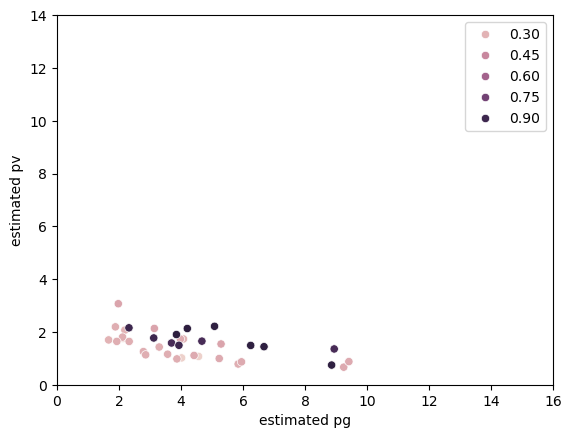

37


,camera,date,lat,lon,pvpg,pv,pg,Eg,Ev,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow
93,delta_junction,02/05/2021,63.867586,-145.761632,0.234979,1.072854,4.565743,1.680912,0.476190,24.021277,0.731000,0.20,0.0,0.000000,16.0,0.000000,1.883530,1.883530,0.20
99,delta_junction,02/05/2021,63.894614,-145.782096,0.252831,1.016108,4.018927,1.840747,0.369396,20.450000,0.593018,0.20,0.0,0.075000,16.0,0.000000,1.702500,1.702500,0.20
193,delta_junction,26/04/2024,63.876595,-145.761632,0.824436,1.753913,2.127408,1.447368,0.625000,27.914286,0.299608,0.20,0.0,0.000000,32.0,0.000000,1.414791,1.414791,0.20
703,lacclair,09/04/2021,46.983632,-71.676199,0.944992,2.068254,2.188648,0.367857,1.416071,21.142857,0.455364,0.30,0.0,0.000000,12.0,2.000000,1.533761,1.533761,0.30
698,lacclair,09/04/2021,46.956605,-71.676199,1.019659,1.696912,1.664196,0.416667,1.133929,24.375000,0.432115,0.30,0.0,0.000000,12.0,2.000000,1.363735,1.363735,0.30
701,lacclair,09/04/2021,46.974623,-71.676199,0.424979,1.733683,4.079452,0.656250,1.258065,23.800000,0.442186,0.30,0.0,0.000000,12.0,1.857143,1.324692,1.324692,0.30
1227,oregon_yp,25/01/2019,44.346323,-121.624889,0.253024,0.978495,3.867199,1.435185,0.566667,21.578947,131.457102,0.32,0.0,1.000000,0.0,0.000000,1.408977,1.408977,0.32
1228,oregon_yp,25/01/2019,44.346323,-121.587111,0.433418,1.428489,3.295866,1.178571,0.540659,21.250000,100.945246,0.32,0.0,1.000000,0.0,0.000000,1.948468,1.948468,0.32
1214,oregon_yp,25/01/2019,44.292268,-121.637482,0.324032,1.156142,3.567988,1.230159,0.667142,22.500000,108.872076,0.32,0.0,0.805556,0.0,0.000000,1.545276,1.545276,0.32
1220,oregon_yp,25/01/2019,44.310286,-121.587111,1.164254,2.192269,1.882982,1.129032,0.676471,27.400000,103.971202,0.32,0.0,1.000000,0.0,0.000000,1.769804,1.769804,0.32


In [16]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_outlier22_th3_1km_noprior_ta.pkl')
# print(df.columns)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg': 'median',
    'Ev': 'median',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] > 0.05)&(df_grouped['FSC'] < 0.95))
    # &(df_grouped['pvpg']>.5)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.8)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.5)&(df_grouped['pv']>2)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<.5)&((df_grouped['FSC'] < .5)|(df_grouped['TreeSnow'] > 0))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)

    &(df_grouped['pv_ratio_mean'] >= 1.3)

    # &(df_grouped['data_quantity'] >= 18)]
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
    # &(df_grouped['layer_flag'] <= .8)&(df_grouped['data_quantity'] > 10)]

plt.figure()
sns.scatterplot(data = data.sort_values('FSC'), x='pg', y='pv', hue='FSC')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,16)
plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(data))
data.sort_values('FSC')

# Plotting ATL08 from the Dataframe

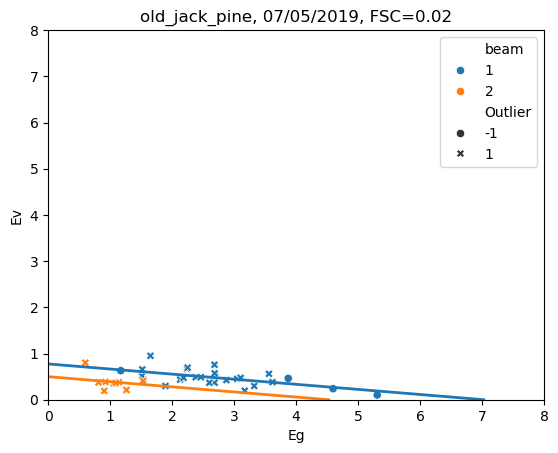

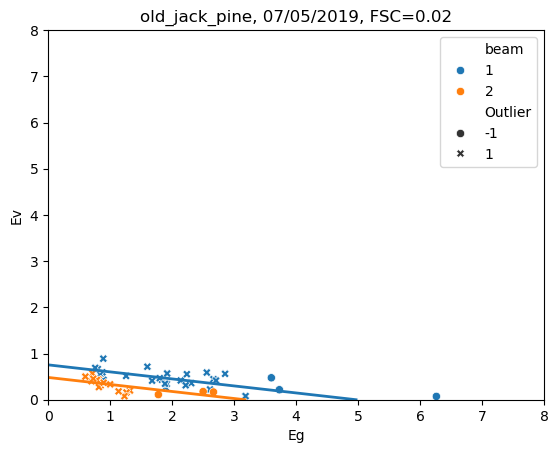

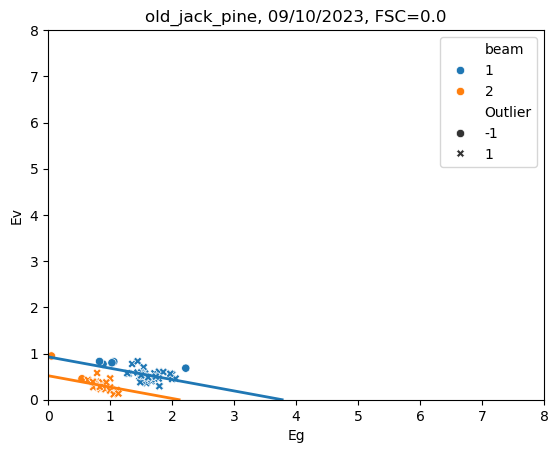

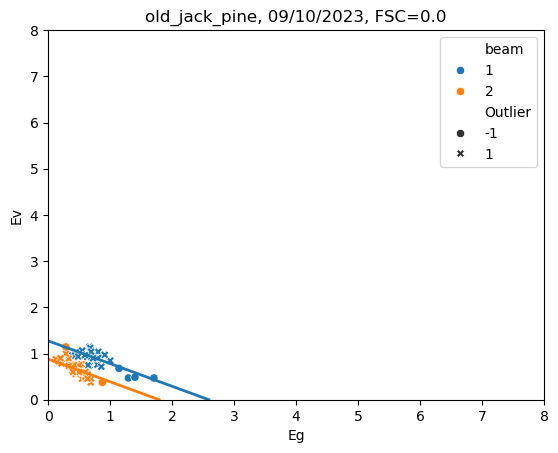

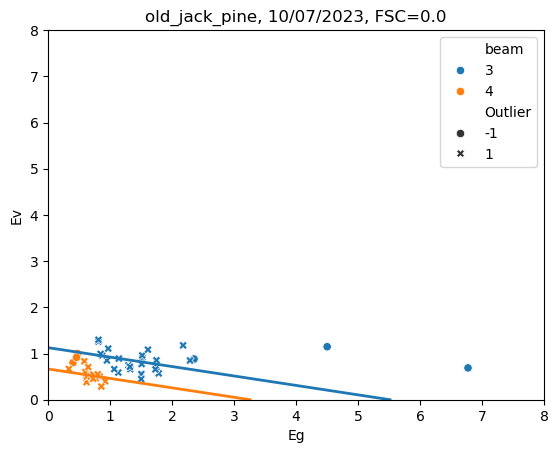

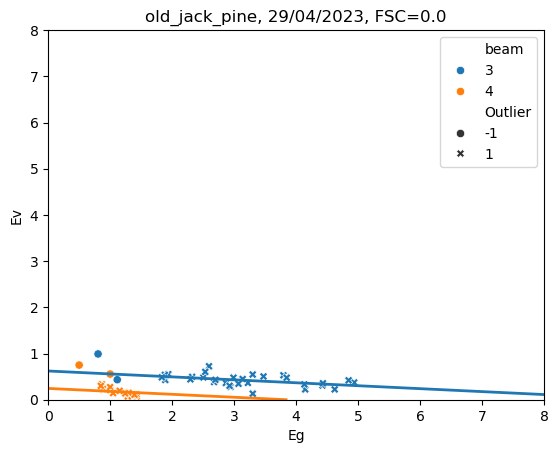

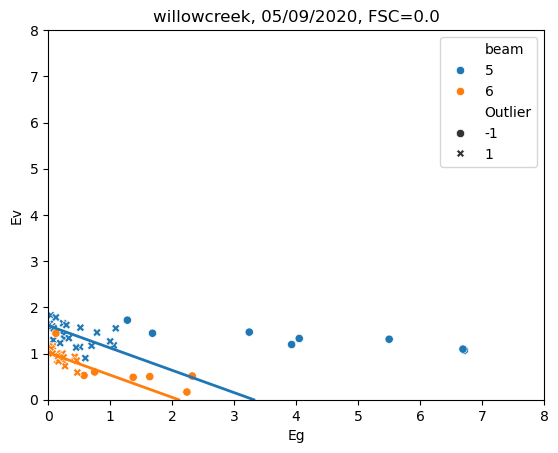

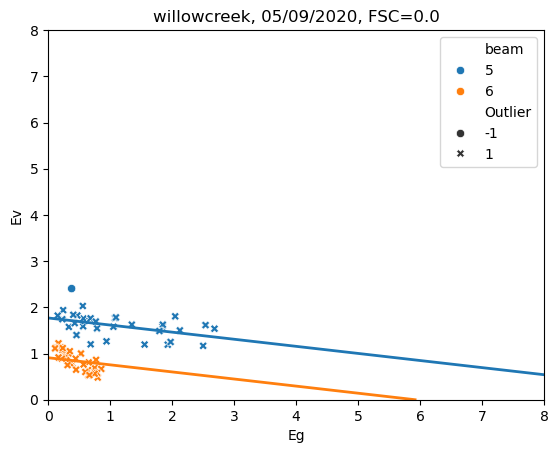

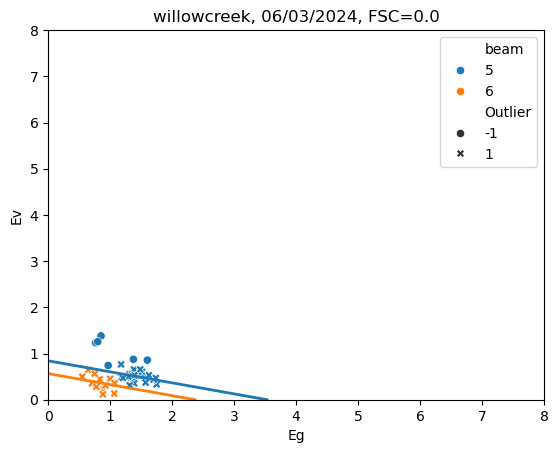

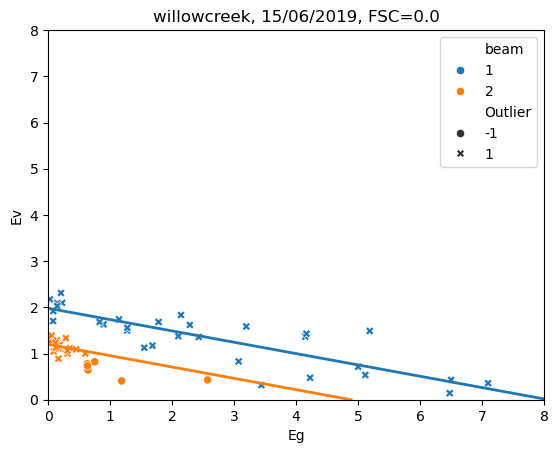

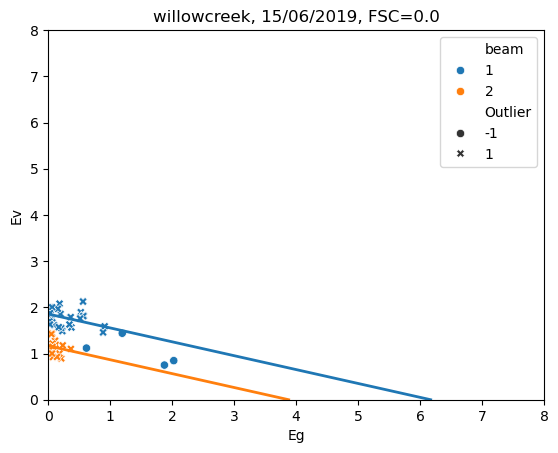

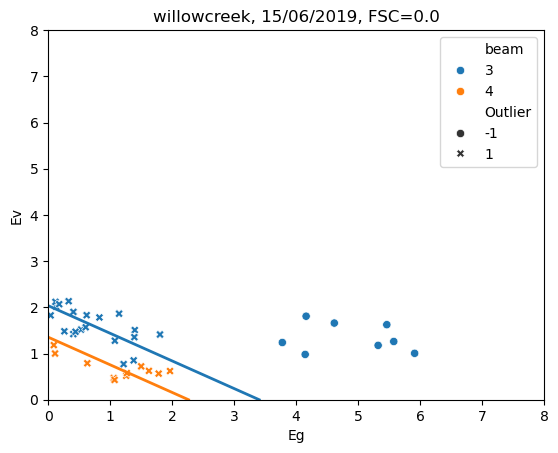

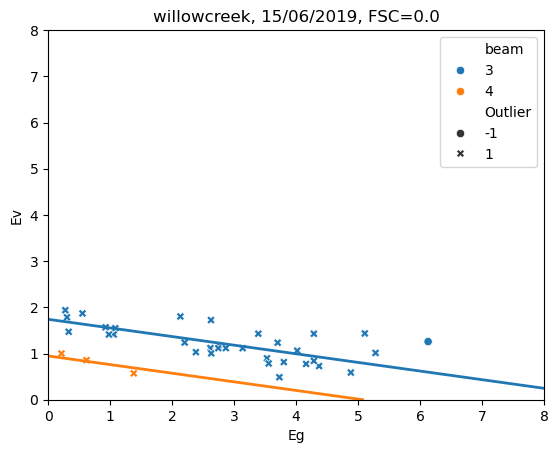

In [91]:
from scripts.parallel_blocks import *
from sklearn.neighbors import LocalOutlierFactor

def df_odr(dataset, init=-1, lb = -100, ub = -1/100, model=parallel_model, res = parallel_residuals, loss='linear',f_scale=.1,
           outlier_removal=False, method='normal', w=[1.0,0.25]):
    intercepts = []
    for b in dataset.beam.unique():
        temp = dataset[dataset['beam']==b]
        X = temp['Eg']
        Y = temp['Ev']
        intercept = starting_intercept(X,Y)
        intercepts.append(min(intercept,16))
    
    dataset = dataset[['Eg', 'Ev', 'beam']]
    beam_dummies = pd.get_dummies(dataset['beam'], prefix='Beam', prefix_sep=' ')
    dataset = dataset.join(beam_dummies)

    cats = dataset.shape[1]-3

    a = [lb] + [0]*cats
    b = [ub] + [16]*cats
    bounds = (a,b)
    
    initial_params = [init] + intercepts

    beam_columns = [col for col in dataset.columns if 'Beam' in col]

    filtered_data = []
    full_data = []

    data_quant = 0

    for beam in beam_columns:
        # Select rows where the current beam is True
        beam_data = dataset[dataset[beam] == True][['Eg', 'Ev', 'beam'] + beam_columns].copy()
        #print(len(beam_data))

        if outlier_removal == False:
            full_data.append(beam_data[['Eg', 'Ev', 'beam'] + beam_columns])
            continue

        if len(beam_data) >= 2:

            beam_data_trans = beam_data.copy()

            # Fit an EllipticEnvelope model
            # envelope = EllipticEnvelope(contamination=outlier_removal, random_state=42)  # Adjust contamination as needed
            lof = LocalOutlierFactor(n_neighbors=outlier_removal, contamination='auto')
            # eg_std = beam_data_trans['Eg'].std()
            # threshold = 3*eg_std
            
            # envelope.fit(beam_data_trans[['Eg', 'Ev']])
            
            # Predict inliers (1) and outliers (-1)
            # beam_data['Outlier'] = envelope.predict(beam_data_trans[['Eg', 'Ev']])
            beam_data['Outlier'] = lof.fit_predict(beam_data_trans[['Eg', 'Ev']])
            # beam_data['Outlier'] = np.where(beam_data['Eg'] > threshold, -1, 1)
            
            beam_filtered = beam_data[beam_data['Outlier'] == 1]
        else:
            beam_filtered = beam_data

        filtered_data.append(beam_filtered[['Eg', 'Ev', 'beam'] + beam_columns])  # Keep only Eg, Ev, and beam columns
        full_data.append(beam_data[['Eg', 'Ev', 'Outlier', 'beam'] + beam_columns])

        data_quant = max(data_quant, len(beam_data))

    full_dataset = pd.concat(full_data).reset_index(drop=True)
    if outlier_removal != False:
    
        # Combine filtered data for all beams, maintaining the original beam columns with True/False values
        filtered_dataset = pd.concat(filtered_data).reset_index(drop=True)
    
        dataset = filtered_dataset.copy()

    X = dataset.drop(columns=['Ev', 'beam'])
    Y = dataset[['Ev']]

    params = least_squares(parallel_residuals,x0=initial_params,args=(X,Y,parallel_model,False,w),loss = loss,f_scale=f_scale,bounds = bounds)

    return params.x, dataset, full_dataset
    
# misclassified.columns
for idx, row in misclassified.iterrows():
    if row['FSC'] <= 0.05:
        plt.figure()
        plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
        
        test_plot = df[(df['camera'] == row['camera']) &
                       (df['date'] == row['date']) &
                       (df['lon'] == row['lon']) &
                       (df['lat'] == row['lat'])].copy()

        params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

        # print(test)

        # Get sorted unique beams (hue order used by seaborn)
        beam_order = sorted(test['beam'].unique())

        # Create mapping from beam label to tab10 color
        tab10 = cm.get_cmap('tab10')
        color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

        # Plot with fixed hue order and palette
        sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
                        hue_order=beam_order, palette=color_map)

        # Plot ODR lines in matching colors
        for b, beam in zip(params[1:], beam_order):
            plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

        plt.xlim(0, 8)
        plt.ylim(0, 8)
        plt.legend()
        plt.show()

        # break